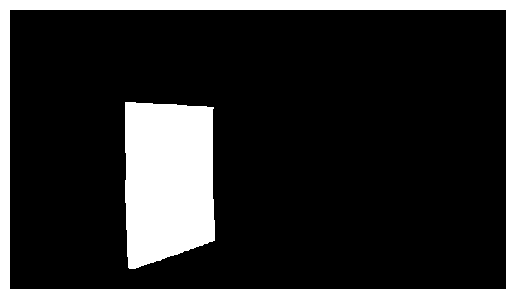

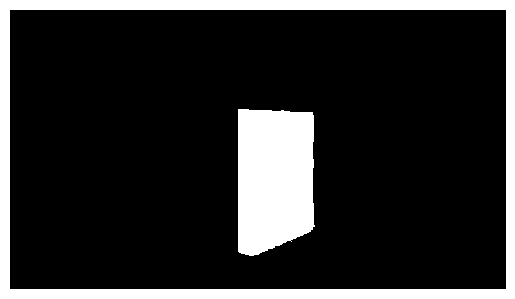

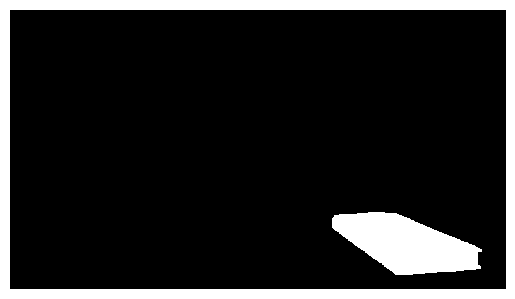

In [51]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import os

#Loading Images
images = {}
for x in os.listdir("masks"):
    images[x] = cv2.imread("masks/" + x)
    images[x]= images[x][:,:,::-1]
    plt.imshow(images[x], interpolation='nearest')
    plt.axis("off")
    plt.show() 

In [2]:
#Function takes parameters number of rows and columns
def PrintImages(images, rows, cols):
    #Creating a Grid, depending on the number of rows and columns
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 10)) 
    #Flattening the axes and taking the number of unwanted plots
    axes = axes.flatten()
    unwantedPlots=len(images)
    #Looping through all the images
    for i, (imageName, image) in enumerate(images.items()):
        #Checking whether exceeded list and setting the number of unwantedPlots starting value
        if i >= rows * cols:
            unwantedPlots=i
            break
        
        #Calculating row and column
        row = i // cols 
        col = i % cols
        
        #Error checking for axes keys
        if row < rows and col < cols:
            axes[i].imshow(image, interpolation='nearest', cmap='gray') #Displaying the image
            axes[i].set_title(imageName) #Setting the title
            axes[i].axis('off') #Removing the axes
    
    #Deleting the extra plots
    for i in range(unwantedPlots, len(axes)):
        fig.delaxes(axes[i])
    #Showing plot
    plt.show()

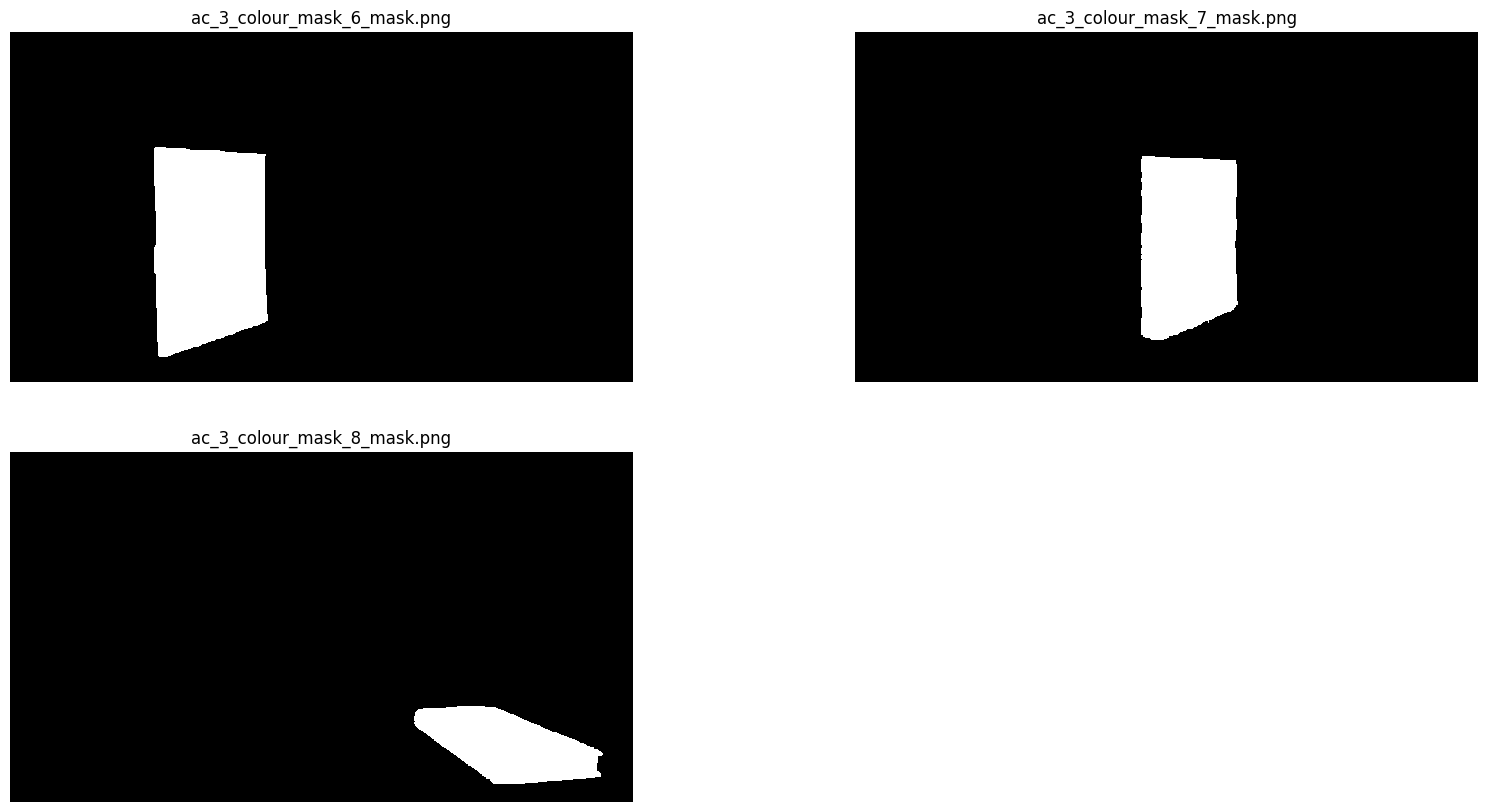

In [5]:
PrintImages(images,2,2)

In [45]:
def mask_to_annotation(mask, type='polygon'):
    '''
    Convert mask to annotation
    '''

    if type == 'polygon':
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        sorted_contours = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1])
        return sorted_contours
    elif type == 'bounding_box':
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        sorted_contours = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1])
        return sorted_contours
        pass

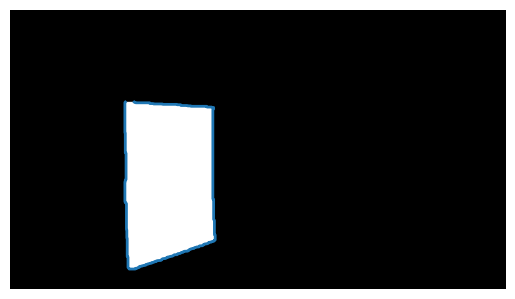

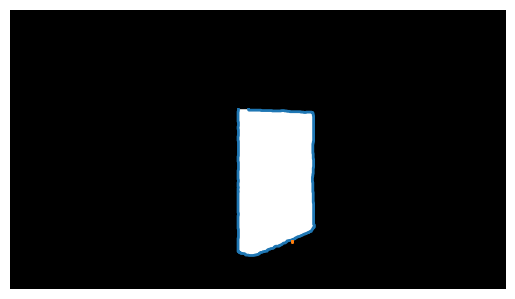

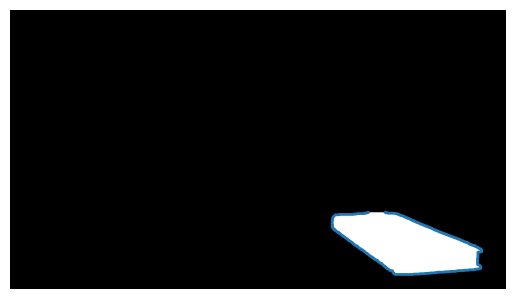

In [46]:
polgon_annotations={}
for name,image in images.items():
    plt.figure()
    polgon_annotations[name]=mask_to_annotation(image, type='polygon')
    for i in range(len(polgon_annotations[name])):
        
        x= polgon_annotations[name][i][:,0,0]
        y= polgon_annotations[name][i][:,0,1]
        plt.imshow(image)
        plt.plot(x, y, linewidth=2)
        plt.axis('off')
        

In [50]:
bounding_box_annotations={}
for name,image in images.items():
    plt.figure()
    bounding_box_annotations[name]=mask_to_annotation(image, type='bounding_box')
    for count,contours in enumerate(bounding_box_annotations[name]):

        x,y,w,h = cv2.boundingRect(contours)
        print(x)
        print(y)
        print(w)
        print(h)
        print()
#         box=bounding_box_annotations[name][y:y+h, x: x+w]
#         #Drawing rectangle for ROI of current line Contour
#         cv2.rectangle(box, (x,y), (x+w, y+h), (40, 100, 250), 2)

#         plt.imshow(box)
#         plt.axis('off')

296
237
234
432

588
256
198
378

726
595
2
3

831
522
387
161



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## COCO Format

In [56]:
project_name="COTS Dataset"
category="directory"

In [83]:
def contours_to_coco(contours):
    coco_data = {
        "info": {
            "description": project_name
        },
        "images": [],
        "annotations": [],
        "categories": []
    }

    annotation_id = 1

    for image_id, image_descriptor in contours.items():
        contour_list = image_descriptor["contours"]

        # Create image entry
        image_entry = {
            "id": image_id,
            "width": image_descriptor["width"],
            "height": image_descriptor["height"],
            "file_name": image_descriptor["file_name"]
        }

        # Create annotation entry
        for contour in contour_list:
            contour = np.array(contour, dtype=np.float32)

            # Check if the contour has enough points
            if contour.shape[0] < 3:
                continue

            # Create annotation entry
            annotation_entry = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": image_id,
                "segmentation": contour.squeeze().tolist(),
                "area": cv2.contourArea(contour),
                "bbox": cv2.boundingRect(contour)
            }

        # Create categories entry
#         category_entry = {
#             "id": annotation_id,
#             "name": bbox
#         }

        coco_data["images"].append(image_entry)
        coco_data["annotations"].append(annotation_entry)

        annotation_id += 1

    return coco_data


polygons = {}
image_id = 1
for name, image in images.items():
    tmp = {}
    tmp["file_name"] = name
    tmp["width"] = image.shape[1]
    tmp["height"] = image.shape[0]
    tmp["contours"] = mask_to_annotation(image, type='polygon')
    polygons[image_id] = tmp
    image_id += 1

data = contours_to_coco(polygons)
with open('annotations.json', 'w') as f:
    json.dump(data, f, indent=4)
